In [28]:
from numpy import genfromtxt
import numpy as np
import math
from pylab import *
import urllib
import os
import matplotlib.pyplot as pl
import pandas as pd
from scipy.stats import lognorm
from sklearn.metrics import mean_squared_error
from __future__ import division
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lmfit import Model
pl.style.use('seaborn-dark-palette')
pl.rc('font',family='Arial')

### constants

In [2]:
temp = 300.
kb = 1.381e-23 
tau0 = 1e-9
mu0 = 4*np.pi*1e-7

In [3]:
def visc_calc(T, mass_fraction):
    glycerolDen = (1273.3-0.6121*T)/1000 			#Density of Glycerol (g/cm3)
    waterDen = (1-math.pow(((abs(T-4))/622),1.7)) 	#Density of water (g/cm3)
    
    ##Andreas Volk polynomial method
    contraction_av = 1-math.pow(3.520E-8*((mass_fraction*100)),3)+math.pow(1.027E-6*((mass_fraction*100)),2)+2.5E-4*(mass_fraction*100)-1.691E-4
    contraction = 1+contraction_av/100
    
    glycerolVisc=0.001*12100*np.exp((-1233+T)*T/(9900+70*T))
    waterVisc=0.001*1.790*np.exp((-1230-T)*T/(36100+360*T))
    
    a=0.705-0.0017*T
    b=(4.9+0.036*T)*np.power(a,2.5)
    alpha=1-mass_fraction+(a*b*mass_fraction*(1-mass_fraction))/(a*mass_fraction+b*(1-mass_fraction))
    A=np.log(waterVisc/glycerolVisc)
    
    viscosity_mix=glycerolVisc*np.exp(A*alpha)
    
    return viscosity_mix

def power(my_list, p):
    return [ x**p for x in my_list ]

def calc_neel(size, k):
    neel = []
    for x in range(len(size)):
        neel.append(tau0*np.exp(k[x]*4*np.pi*(1e-9*float(size[x]))**3*(24*kb*temp)**(-1)))
    return neel

def calc_brown(eta, hsize):
    brown = []
    for x in range(len(eta)):
        brown.append(eta[x]*np.pi*(hsize[x]*1e-9)**3*(2*kb*temp)**(-1))
    return brown

def vol(my_list):
    return[ np.pi*(1e-9*x)**3/6. for x in my_list ]


### import data

In [4]:
freqs = []
fields = []
size = []
sigma = []
g = []
m = []
third = []
fifth = []
label = []
hsize = []
#phase1 = []
#phase3 = []
hlabel = []
eta = []
Dfifth = []
Dthird = []
Dphase = []
ms = []
K = []

for f in os.listdir('MPS-march'):
    if f[-5] == "F":
        filename = 'MPS-march/' + f
        s = str.split(f,"-")
        if s[0][:-3] == "40":
            freqs.append(40200)
        elif s[0][:-3] == "25" or s[0][:-3] == "26":
            freqs.append(25250)
        elif s[0][:-3] == "15":
            freqs.append(15500)
        filedata = np.genfromtxt(filename, delimiter=',')
        fields.append(abs(filedata[1,0]))
        if s[2][:-2] == "25":
            size.append(25.2)
            sigma.append(0.09)
            hsize.append(90.)
            ms.append(370000.)
        elif s[2][:-2] == "28":
            size.append(27.7)
            sigma.append(0.1)
            hsize.append(75.)
            ms.append(390000.)
        elif s[2][:-2] == "22":
            size.append(21.9)
            sigma.append(0.05)
            hsize.append(90.)
            ms.append(350000.)
        if s[3][0] == "g":
            g.append(int(s[3][1:]))
            eta.append(visc_calc(25, int(s[3][1:])*0.01*135/150.))
            m.append(None)
            label.append('g')
        elif s[3][0] == "m":
            m.append(int(s[3][1:]))
            g.append(None)
            eta.append(None)
            label.append('m')
        hlabel.append(s[1][:-2])
        moment = np.append(filedata[1:,1], filedata[1:,4])
        third.append(abs(np.fft.fft(moment)[3]))
        fifth.append(abs(np.fft.fft(moment)[5]))
        K.append(5000.)
        #phase1.append(np.angle(np.fft.fft(moment)[1]))
        #phase3.append(np.angle(np.fft.fft(moment)[3]))
        datfile = "MPS-march/"+ s[0] + "-" + s[1] + "-" + s[2] + "-" + s[3] + "-_MPS_dat.csv"
        datfiledata = np.genfromtxt(datfile, delimiter=',',invalid_raise=False,missing_values='')[1:,:]
        Dthird.append(datfiledata[1,15])
        Dfifth.append(datfiledata[2,15])
        Dphase.append(datfiledata[1,18])
        
data = pd.DataFrame({'frequency': freqs, 'field': fields,'size': size, 'sigma': sigma, \
                     'viscosity': g, 'mannitol': m, 'third': third, 'fifth': fifth, 'label': label, 'hsize': hsize, \
                     'hlabel': hlabel, 'eta': eta, 'dthird': Dthird, 'dfifth': Dfifth,'dphase': Dphase, 'Ms': ms,'K': K})

data['5:3'] = data['fifth']/data['third']
data['D5:3'] = data['dfifth']/data['dthird']
data['angF'] = 2*np.pi*data['frequency']
#data['rTime1'] = np.tan(data['phase1']/data['angF'])
#data['rTime3'] = np.tan(data['phase3']/data['angF'])
data['tauB'] = data['eta']*np.pi*(power(1e-9*data['hsize'], 3))*(2*kb*temp)**(-1)
data['tauN'] = calc_neel(data['size'], data['K'])
data['Vc'] = vol(data['size'])

/Users/shasha/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:66: ConversionWarning: Some errors were detected !
    Line #14 (got 14 columns instead of 24)
    Line #15 (got 14 columns instead of 24)
    Line #16 (got 14 columns instead of 24)
    Line #17 (got 14 columns instead of 24)
    Line #18 (got 14 columns instead of 24)
    Line #19 (got 14 columns instead of 24)
    Line #20 (got 14 columns instead of 24)
    Line #21 (got 14 columns instead of 24)
    Line #22 (got 14 columns instead of 24)
    Line #23 (got 14 columns instead of 24)
    Line #24 (got 14 columns instead of 24)
    Line #25 (got 14 columns instead of 24)
    Line #26 (got 14 columns instead of 24)
    Line #27 (got 14 columns instead of 24)
/Users/shasha/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:66: ConversionWarning: Some errors were detected !
    Line #34 (got 14 columns instead of 24)
    Line #35 (got 14 columns instead of 24)
    Line #36 (got 14 columns instead of 24)


### calculate Langevin harmonics

In [5]:
for index, row in data.iterrows():
    T = row['frequency']**(-1)
    t = np.arange(0,T,T/1000.)
    H = 0.001*row['field']*np.cos(row['angF']*t)
    V = (4/3)*np.pi*(row['size']*1e-9/2)**3
    xi = row['Ms']*V*H/(kb*temp)
    L = np.cosh(xi)/np.sinh(xi) - 1/xi
    data.loc[index,'L5:3'] = abs(np.fft.fft(L)[5])/abs(np.fft.fft(L)[3])

### clean data

In [6]:
print(len(data))
trimdata = data[data['5:3'] < 1]
print(len(trimdata))
trimdata = trimdata[(trimdata['mannitol'] < 12) | (trimdata['label'] == 'g')]
print(len(trimdata))
trimdata = trimdata[trimdata['field'] > 5]
print(len(trimdata))
trimdata = trimdata[trimdata['third'] > 1e-9]
print(len(trimdata))
trimdata = trimdata[trimdata['fifth'] > 1e-9]
print(len(trimdata))

for index, row in trimdata.iterrows():
    if row['frequency'] == 40200:
        if row['field'] > 36:
            if row['viscosity'] == 0.0:
                trimdata.drop(index, inplace=True)
        elif row['field'] < 5:
            if row['viscosity'] > 82:
                trimdata.drop(index, inplace=True)
        elif row['field'] > 12:
            if row['field'] < 15:
                if row['mannitol'] == 11.0:
                    if row['size'] == 27.7:
                        trimdata.drop(index, inplace=True)
                elif row['mannitol'] == 10.0:
                    if row['size'] == 25.2:
                        trimdata.drop(index, inplace=True)
    elif row['frequency'] == 25250:
        if row['field'] > 32:
            if row['field'] < 35:
                if row['viscosity'] == 85.0:
                    if row['size'] == 25.2:
                        trimdata.drop(index, inplace=True)
    elif row['frequency'] == 15500:
        if row['field'] > 15.5:
            if row['field'] < 19:
                if row['viscosity'] == 0.0:
                    if row['size'] == 27.7:
                        trimdata.drop(index, inplace=True)
        if row['field'] > 7:
            if row['field'] < 10:
                if row['mannitol'] == 11.0:
                    if row['size'] == 27.7:
                        trimdata.drop(index, inplace=True)

    if row['viscosity'] == 95.0:
        trimdata.drop(index, inplace=True)
    elif row['viscosity'] == 85.0:
        if row['size'] == 21.9:
            trimdata.drop(index, inplace=True)
        elif row['size'] == 27.7:
            trimdata.drop(index, inplace=True)
    elif row['viscosity'] == 4.0:
        if row['size'] == 25.2:
            if row['frequency'] == 25250:
                if row['field'] > 35:
                    trimdata.drop(index, inplace=True)
            
    if row['mannitol'] < 10:
        if row['size'] == 25.2:
            trimdata.drop(index, inplace=True)
        elif row['size'] == 27.7:
            trimdata.drop(index, inplace=True)
                
print(len(trimdata))

1110
1086
1078
1004
1003
957
747


### import simulation data

In [7]:
freqs = []
fields = []
size = []
third = []
fifth = []
hsize = []
sigma = []
eta = []
b = []
K = []
phase1 = []
phase3 = []
gyro = []

for f in os.listdir('fits2'):
    if f[-1] == 'v':
        filename = 'fits2/' + f
        filedata = np.genfromtxt(filename, delimiter=',')
        f = f[:-4]
        s = str.split(f,"_")
        size.append(float(s[0][:-2]))
        fields.append(float(s[1][:-2]))
        freqs.append(int(s[2][:-3])*1000)
        sigma.append(0.1)
        eta.append(8.9e-4)
        moment = filedata[:,1]
        third.append(abs(np.fft.fft(moment)[3]))
        fifth.append(abs(np.fft.fft(moment)[5]))
        phase1.append(np.angle(np.fft.fft(moment)[1]))
        phase3.append(np.angle(np.fft.fft(moment)[3]))
        if s[-1] == "frozen":
            b.append("off")
        else:
            b.append("on")     
        g = 1.
        h = 50.
        k = 5000.
        for ss in range(2,len(s)):
            if s[ss][0] == "g":
                g = float(s[ss][1:])
            if s[ss][0] == "K":
                k = 1000*float(s[ss][1:])
                if k > 25000:
                    k /= 1000.
            if s[ss][0] == "H":
                h = float(s[ss][1:])
        K.append(k)
        hsize.append(h)
        gyro.append(g)
            
         
sdata = pd.DataFrame({'frequency': freqs, 'field': fields,'size': size, 'sigma': sigma, \
                     'third': third, 'fifth': fifth, 'hsize': hsize, 'eta': eta, 'b': b, \
                     'K': K, 'phase1': phase1, 'phase3': phase3, 'gyro': gyro})

sdata['5:3'] = sdata['fifth']/sdata['third']
sdata['angF'] = 2*np.pi*sdata['frequency']
sdata['Vc'] = vol(sdata['size'])
sdata['Ms'] = 393023 * (1 - np.exp(-2.78258e8 * sdata['size']*1e-9))**57.87571 
sdata['tauB'] = calc_brown(sdata['eta'],sdata['hsize'])
sdata['tauN'] = calc_neel(sdata['size'], sdata['K'])
sdata['tan1'] = abs(np.tan(sdata['phase1']))
sdata['tan3'] = abs(np.tan(sdata['phase3']))
sdata['tau'] = sdata['tan1']/sdata['angF']

In [8]:
for index, row in sdata.iterrows():
    T = row['frequency']**(-1)
    t = np.arange(0,T,T/1000.)
    H = 0.001*row['field']*np.cos(row['angF']*t)
    V = (4/3)*np.pi*(row['size']*1e-9/2)**3
    xi = row['Ms']*V*H/(kb*temp)
    L = np.cosh(xi)/np.sinh(xi) - 1/xi
    sdata.loc[index,'L5:3'] = abs(np.fft.fft(L)[5])/abs(np.fft.fft(L)[3])

### define fitting functions

In [9]:
def taufunc1(h, ms, v,gamma, A, B):
    xi = ms*v*h/(kb*temp)
    return gamma*(np.sqrt(1 + A*xi**B))**(-1)

def taufunc2(xi,gamma, A, B):
    return gamma*np.exp(-A*xi**(B))

def taufunc3(xi, A, B):
    return np.exp(-np.log(xi/A)**2/(2*B**2))*(np.sqrt(2*np.pi)*xi*B)

def taufuncN(h, ms, v, tN,A, B):
    xi = ms*v*h/(kb*temp)
    return tN*(np.sqrt(1 + A*xi**B))**(-1)

def taufuncB(h, ms, v, tB, A, B):
    xi = ms*v*h/(kb*temp)
    return tB*(np.sqrt(1 + A*xi**B))**(-1)

def taufuncE(h, ms, v, tN,tB, A, B):
    xi = ms*v*h/(kb*temp)
    tE = (tN*tB)/(tN + tB)
    return tE*(np.sqrt(1 + A*xi**B))**(-1)

def linefit(x, m, bb):
    return m*x + bb

### example Neel fit to tau

{'B': 1.9564589846947911, 'A': 26.062092758600524}
2.56285248911e-14


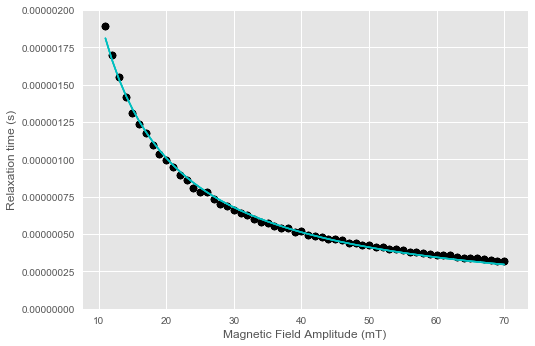

In [70]:
tmodelN = Model(taufuncN, independent_vars=['h','v', 'ms','tN'])
tmodelN.set_param_hint('A', min=0)
tmodelN.set_param_hint('B', min=0, max=5)

traindata = sdata[(sdata['size'] == 24) &(sdata['frequency'] == 25000)& (sdata['K'] == 5000)& (sdata['gyro'] == 100) &(sdata['b'] == "off") & (sdata['field'] > 10)]
cutdata = sdata[(sdata['size'] == 24) & (sdata['frequency'] == 25000)& (sdata['K']== 5000)& (sdata['gyro'] == 100)& (sdata['b'] == "off") & (sdata['field'] > 10)]

result = tmodelN.fit(traindata['tau'], h = 0.001*traindata['field'], v = traindata['Vc'], ms = traindata['Ms'], tN=traindata['tauN']*10, \
                     A = 10000, B=1, nan_policy='omit', method='leastsq')

print(result.values)
print(result.chisqr)

cutdata = cutdata.sort_values(by=['field'])
scatter(cutdata['field'], cutdata['tau'], c="black")
plot(cutdata['field'], taufuncN(h = 0.001*cutdata['field'], v = cutdata['Vc'], ms = cutdata['Ms'],tN=cutdata['tauN']*10,**result.values),c="c", lw=1.5)
ylim(0,0.2e-5)
ylabel('Relaxation time (s)')
xlabel('Magnetic Field Amplitude (mT)')
#savefig('tau_neel_25khz_fit.pdf',bbox_inches='tight')
show()

### example fit to tau

{'B': 1.9065125912803316, 'A': 8.5293326754073053}
1.46248144188e-14
{'B': 1.9564589846947911, 'A': 26.062092758600524}
2.56285248911e-14


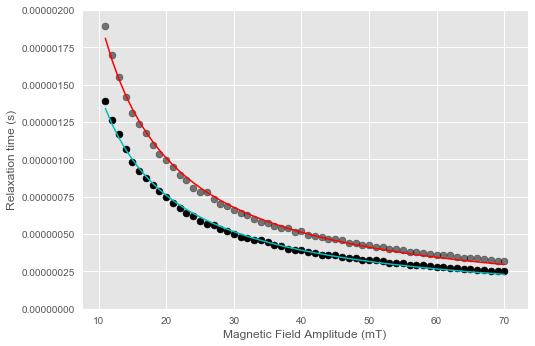

In [91]:
tmodelE = Model(taufuncE, independent_vars=['h','v', 'ms','tN', 'tB'])
tmodelE.set_param_hint('A', min=0)
tmodelE.set_param_hint('B', min=0)

tmodelN = Model(taufuncN, independent_vars=['h','v', 'ms','tN'])
tmodelN.set_param_hint('A', min=0)
tmodelN.set_param_hint('B', min=0, max=5)

traindataE = sdata[(sdata['size'] == 24) &(sdata['frequency'] == 25000)& (sdata['K'] == 5000)& (sdata['gyro'] == 100) &(sdata['b'] == "on") & (sdata['field'] > 10)]
cutdataE = sdata[(sdata['size'] == 24) & (sdata['frequency'] == 25000)& (sdata['K']== 5000)& (sdata['gyro'] == 100)& (sdata['b'] == "on") & (sdata['field'] > 10)]

resultE = tmodelE.fit(traindataE['tau'], h = 0.001*traindataE['field'], v = traindataE['Vc'], ms = traindataE['Ms'], tN=traindataE['tauN']*10,tB=traindataE['tauB'], \
                     A = 26, B=1.95, nan_policy='omit', method='leastsq')

traindata = sdata[(sdata['size'] == 24) &(sdata['frequency'] == 25000)& (sdata['K'] == 5000)& (sdata['gyro'] == 100) &(sdata['b'] == "off") & (sdata['field'] > 10)]
cutdata = sdata[(sdata['size'] == 24) & (sdata['frequency'] == 25000)& (sdata['K']== 5000)& (sdata['gyro'] == 100)& (sdata['b'] == "off") & (sdata['field'] > 10)]

result = tmodelN.fit(traindata['tau'], h = 0.001*traindata['field'], v = traindata['Vc'], ms = traindata['Ms'], tN=traindata['tauN']*10, \
                     A = 10000, B=1, nan_policy='omit', method='leastsq')

print(resultE.values)
print(resultE.chisqr)

print(result.values)
print(result.chisqr)


cutdataE = cutdataE.sort_values(by=['field'])
scatter(cutdataE['field'], cutdataE['tau'], c="black")
plot(cutdataE['field'], taufuncE(h = 0.001*cutdataE['field'], v = cutdataE['Vc'], ms = cutdataE['Ms'],tN=cutdataE['tauN']*10,tB=cutdataE['tauB'],**resultE.values),c="c", lw=1.5)

cutdata = cutdata.sort_values(by=['field'])
scatter(cutdata['field'], cutdata['tau'], c="black", alpha=0.5)
plot(cutdata['field'], taufuncN(h = 0.001*cutdata['field'], v = cutdata['Vc'], ms = cutdata['Ms'],tN=cutdata['tauN']*10,**result.values),c="r", lw=1.5)
ylim(0,0.2e-5)
ylabel('Relaxation time (s)')
xlabel('Magnetic Field Amplitude (mT)')

#savefig('tau_both_25khz_fit.pdf',bbox_inches='tight')
show()

### fit to tauN

In [13]:
tmodelN = Model(taufuncN, independent_vars=['h','v', 'ms', 'tN'])
tmodelN.set_param_hint('A', min=0)
tmodelN.set_param_hint('B', min=0, max=5)

size = []
Vc = []
A = []
B = []
chi = []

for x in range(16,36):
    traindata = sdata[(sdata['size'] == float(x)) & (sdata['frequency'] == 25000)& (sdata['K'] == 5000)& (sdata['gyro'] == 100) &(sdata['b'] == "off")]

    result = tmodelN.fit(traindata['tau'], h = 0.001*traindata['field'], v = traindata['Vc'], ms = traindata['Ms'], tN=traindata['tauN']*10, \
                     A = 1, B=1, nan_policy='omit', method='leastsq')

    size.append(float(x))
    A.append(result.params['A'].value)
    B.append(result.params['B'].value)
    chi.append(result.chisqr)
    Vc.append((4/3.)*np.pi*(float(x)/2.)**3)
    
    
taufitN = pd.DataFrame({'size': size, 'Vc':Vc,'A': A, 'B': B, 'chi': chi})

In [14]:
taufitN.describe()

,A,B,Vc,chi,size
count,2.000000e+01,20.000000,20.000000,2.000000e+01,20.00000
mean,3.905031e+07,2.425195,10013.826583,1.212703e-06,25.50000
std,1.665258e+08,1.571555,6345.932701,5.239474e-06,5.91608
min,2.176037e-14,0.000126,2144.660585,1.992284e-14,16.00000
25%,2.023113e-01,1.950270,4683.983747,3.401819e-14,20.75000
50%,6.308107e+02,2.093278,8692.001474,6.813197e-14,25.50000
75%,5.629213e+05,2.667812,14502.507987,2.581501e-11,30.25000
max,7.459428e+08,4.999979,22449.297504,2.346037e-05,35.00000


{'m': 0.032612976761578372, 'bb': 1.1880557258295164}
0.00102538866822


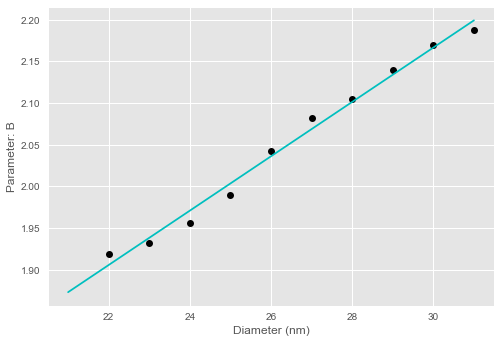

In [77]:
lfit = Model(linefit, independent_vars=['x'])
lfit.set_param_hint('m', min=0)
lfit.set_param_hint('bb', min=0)
result = lfit.fit(taufitN[(taufitN['chi'] < 1e-13)&(taufitN['size'] >21)]['B'], x=taufitN[(taufitN['chi'] < 1e-13)&(taufitN['size'] >21)]['size'],  \
                     m=.3, bb=1,nan_policy='omit', method='leastsq')
print(result.values)
print(result.chisqr)

pl.plot(taufitN[(taufitN['chi'] < 1e-13)&(taufitN['size']>21)]['size'], \
        taufitN[(taufitN['chi'] < 1e-13)&(taufitN['size']>21)]['B'],marker = 'o', linestyle="None", c="black")
pl.plot(taufitN[(taufitN['chi'] < 1e-13)]['size'],linefit(taufitN[(taufitN['chi'] < 1e-13)]['size'],**result.values),c="c")

ylabel('Parameter: B')
xlabel('Diameter (nm)')
#savefig('tau_neel_Bfit.pdf',bbox_inches='tight')
pl.show()

{'m': 0.0020210193088183726, 'bb': -11.387600194225666}
0.308496385436


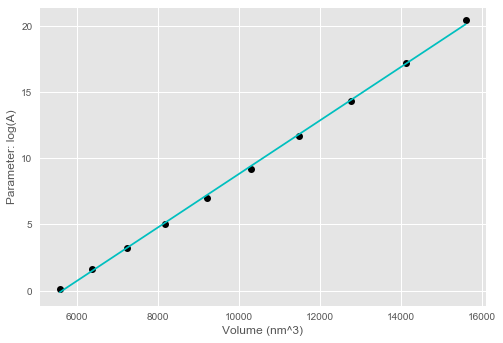

In [80]:
lfit = Model(linefit, independent_vars=['x'])
lfit.set_param_hint('m', min=0)

taufitN['logN'] = np.log(taufitN[(taufitN['chi'] < 1e-13)&(taufitN['size'] >21)]['A'])
cut = taufitN[(taufitN['chi'] < 1e-13)&(taufitN['size'] >21)]

result = lfit.fit(cut['logN'], x=cut['Vc'],  \
                     m=100000, bb=0,nan_policy='omit', method='leastsq')
print(result.values)
print(result.chisqr)

pl.plot(cut['Vc'], cut['logN'],marker = 'o', linestyle="None",c="black")
pl.plot(cut['Vc'] ,linefit(cut['Vc'],**result.values),c="c")
ylabel('Parameter: log(A)')
xlabel('Volume (nm^3)')
#savefig('tau_neel_logAfit.pdf',bbox_inches='tight')
pl.show()

### fit to tauE

In [18]:
tmodelE = Model(taufuncE, independent_vars=['h','v', 'ms', 'tB', 'tN'])
tmodelE.set_param_hint('A', min=0)
tmodelE.set_param_hint('B', min=0, max=5)

size = []
Vc = []
A = []
B = []
chi = []

for x in range(16,36):
    traindata = sdata[(sdata['size'] == float(x)) & (sdata['frequency'] == 25000)& (sdata['K'] == 5000)& (sdata['gyro'] == 100) &(sdata['b'] == "off")]

    result = tmodelE.fit(traindata['tau'], h = 0.001*traindata['field'], v = traindata['Vc'], ms = traindata['Ms'], tB=traindata['tauB'],tN=traindata['tauN']*10, \
                     A = 1, B=1, nan_policy='omit', method='leastsq')

    size.append(float(x))
    A.append(result.params['A'].value)
    B.append(result.params['B'].value)
    chi.append(result.chisqr)
    Vc.append((4/3.)*np.pi*(float(x)/2.)**3)
    
    
taufitE = pd.DataFrame({'size': size, 'Vc':Vc,'A': A, 'B': B, 'chi': chi})

In [19]:
taufitE.describe()

,A,B,Vc,chi,size
count,2.000000e+01,20.000000,20.000000,2.000000e+01,20.00000
mean,1.230446e+00,1.878184,10013.826583,3.731510e-12,25.50000
std,1.567790e+00,0.880644,6345.932701,1.060533e-11,5.91608
min,2.569056e-12,0.000096,2144.660585,2.061536e-14,16.00000
25%,1.296427e-01,1.953096,4683.983747,3.516217e-14,20.75000
50%,5.084814e-01,2.094884,8692.001474,6.906902e-14,25.50000
75%,1.942281e+00,2.208049,14502.507987,1.351374e-13,30.25000
max,5.013294e+00,3.653136,22449.297504,4.430150e-11,35.00000


{'m': 0.029068735911438548, 'bb': 1.2811149951568024}
0.00291222558245


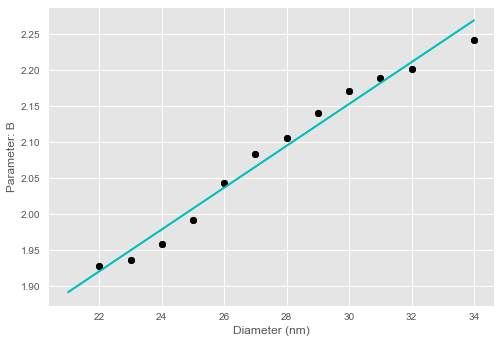

In [82]:
lfit = Model(linefit, independent_vars=['x'])
lfit.set_param_hint('m', min=0)
lfit.set_param_hint('bb', min=0)
result = lfit.fit(taufitE[(taufitE['chi'] < 1e-13)&(taufitE['size'] >21)]['B'], x=taufitE[(taufitE['chi'] < 1e-13)&(taufitE['size'] >21)]['size'],  \
                     m=.3, bb=1,nan_policy='omit', method='leastsq')
print(result.values)
print(result.chisqr)
pl.plot(taufitE[(taufitE['chi'] < 1e-13)&(taufitE['size']>21)]['size'], taufitE[(taufitE['chi'] < 1e-13)&(taufitE['size']>21)]['B'],marker = 'o', linestyle="None",c="black")
pl.plot(taufitE[(taufitE['chi'] < 1e-13)]['size'],linefit(taufitE[(taufitE['chi'] < 1e-13)]['size'],**result.values),c="c")
ylabel('Parameter: B')
xlabel('Diameter (nm)')
#savefig('tau_eff_Bfit.pdf',bbox_inches='tight')
pl.show()

{'B': 0.075727849465755684, 'A': 24.991653338090821}
1.47349531195


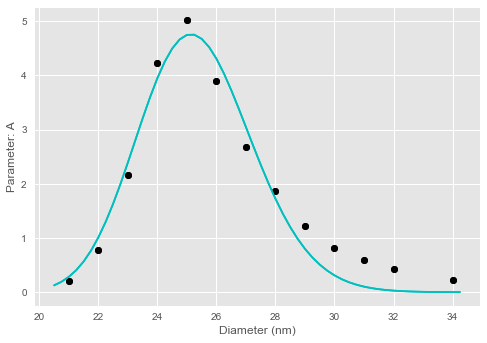

In [84]:
logfit = Model(taufunc3, independent_vars=['xi'])

result = logfit.fit(taufitE[(taufitE['chi'] < 1e-13)]['A'], xi=taufitE[(taufitE['chi'] < 1e-13)]['size'],  \
                     A=25,B=.1,nan_policy='omit', method='leastsq')

print(result.values)
print(result.chisqr)

sizes = np.arange(20.5,34.5,0.25)
pl.plot(taufitE[(taufitE['chi'] < 1e-13)]['size'], \
        taufitE[(taufitE['chi'] < 1e-13)]['A'],marker = 'o', linestyle="None",c="black")
pl.plot(sizes,taufunc3(xi=sizes,**result.values),c="c")
ylabel('Parameter: A')
xlabel('Diameter (nm)')
#savefig('tau_eff_Afit.pdf',bbox_inches='tight')
pl.show()

### calculate effective relaxation times

In [22]:
sdata['tauEff'] = sdata['tauN']*sdata['tauB']*((sdata['tauN'] + sdata['tauB'])* \
                    np.sqrt(1 + taufunc3(xi=sdata['size'], A=25, B=0.076)*(sdata['Ms']*sdata['Vc']* \
                    sdata['field']/(kb*temp))**(0.029*sdata['size'] + 1.28)))**(-1)

trimdata['tauEff'] = trimdata['tauN']*trimdata['tauB']*((trimdata['tauN'] + trimdata['tauB'])* \
                    np.sqrt(1 + taufunc3(xi=trimdata['size'], A=25, B=0.076)*(trimdata['Ms']*trimdata['Vc']* \
                    trimdata['field']/(kb*temp))**(0.029*trimdata['size'] + 1.28)))**(-1)

### fit to 5:3 data

In [23]:
def funcM(ratio, h, v, ms, tau, omega, A, B, beta):
    xi = ms*v*h/(kb*temp)
    return ratio*(1 + A*xi**B*(omega*tau)**beta)**(-1)

{'beta': 1.4810321421813066, 'B': 4.8404902308618603e-10, 'A': 11406.825240112057}
0.068181391036


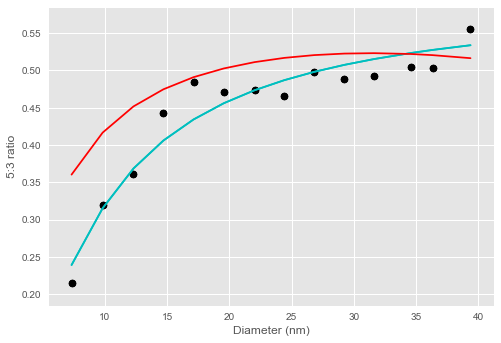

In [90]:
traindata = trimdata[(trimdata['frequency'] == 25250)& (trimdata['viscosity'] == 0.0)]
cutdata = traindata[(traindata['size'] == 27.7)]

modelM = Model(funcM, independent_vars=['ratio','h', 'tau','v', 'ms','omega'])
modelM.set_param_hint('A', min=0)
modelM.set_param_hint('B', min=0)
modelM.set_param_hint('beta', min=0)

result = modelM.fit(traindata['5:3'], ratio=traindata['L5:3'], h=0.001*traindata['field'], v = traindata['Vc'], tau = traindata['tauEff'], \
                    ms = traindata['Ms'], omega = traindata['angF'],A = 1, B= 1, beta = 1.1, nan_policy='omit', method='leastsq')
result2 = modelM.fit(traindata['5:3'], ratio=traindata['L5:3'], h=0.001*traindata['field'], v = traindata['Vc'], tau = traindata['tauB'], \
                    ms = traindata['Ms'], omega = traindata['angF'],A = 1, B= 1, beta = 1.1, nan_policy='omit', method='leastsq')


print(result.values)
print(result.chisqr)

cutdata = cutdata.sort_values(by=['field'])
scatter(cutdata['field'], cutdata['5:3'],c="black")
plot(cutdata['field'], funcM(ratio=cutdata['L5:3'],h=0.001*cutdata['field'], v = cutdata['Vc'], tau=cutdata['tauEff'],ms = cutdata['Ms'],omega=cutdata['angF'],**result.values),c="c")
plot(cutdata['field'], funcM(ratio=cutdata['L5:3'],h=0.001*cutdata['field'], v = cutdata['Vc'], tau=cutdata['tauB'],ms = cutdata['Ms'],omega=cutdata['angF'],**result2.values),c="r")

ylabel('5:3 ratio')
xlabel('Diameter (nm)')
#savefig('5t3_28nm_25khz_fit.pdf',bbox_inches='tight')
show()

{'beta': 1.4810321421813066, 'B': 4.8404902308618603e-10, 'A': 11406.825240112057}
0.068181391036


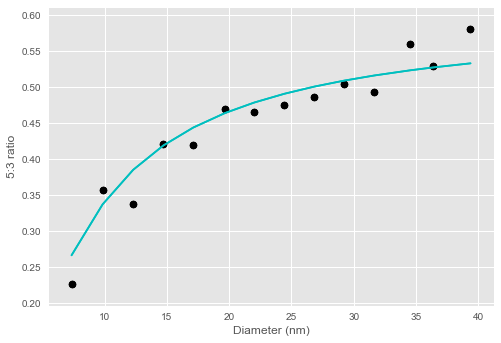

In [88]:
traindata = trimdata[(trimdata['frequency'] == 25250)& (trimdata['viscosity'] == 0.0)]
cutdata = traindata[(traindata['size'] == 25.2)]

modelM = Model(funcM, independent_vars=['ratio','h', 'tau','v', 'ms','omega'])
modelM.set_param_hint('A', min=0)
modelM.set_param_hint('B', min=0)
modelM.set_param_hint('beta', min=0)

result = modelM.fit(traindata['5:3'], ratio=traindata['L5:3'], h=0.001*traindata['field'], v = traindata['Vc'], tau = traindata['tauEff'], \
                    ms = traindata['Ms'], omega = traindata['angF'],A = 1, B= 1, beta = 1.1, nan_policy='omit', method='leastsq')


print(result.values)
print(result.chisqr)

cutdata = cutdata.sort_values(by=['field'])
scatter(cutdata['field'], cutdata['5:3'],c="black")
plot(cutdata['field'], funcM(ratio=cutdata['L5:3'],h=0.001*cutdata['field'], v = cutdata['Vc'], tau=cutdata['tauEff'],ms = cutdata['Ms'],omega=cutdata['angF'],**result.values),c="c")

ylabel('5:3 ratio')
xlabel('Diameter (nm)')
#savefig('5t3_25nm_25khz_fit.pdf',bbox_inches='tight')
show()

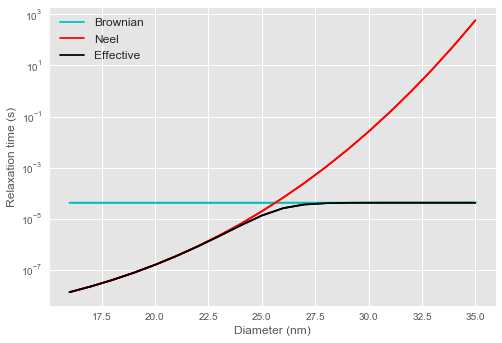

In [98]:
cutdata = sdata[(sdata['b'] == 'on')]

#pl.semilogy(cutdata['size'], cutdata['tau'],linestyle='None',marker='.')
#pl.semilogy(cutdata['size'], cutdata['tauEff'],linestyle='None',marker='.')
cutdata = cutdata.sort_values(by=['size'])
pl.semilogy(cutdata['size'], cutdata['tauB'],c='c')
pl.semilogy(cutdata['size'], cutdata['tauN'],c='r')
pl.semilogy(cutdata['size'], cutdata['tauN']*cutdata['tauB']/(cutdata['tauN']+cutdata['tauB']),c='black')
pl.legend(['Brownian','Neel','Effective'],fontsize=12)
pl.ylabel('Relaxation time (s)')
pl.xlabel('Diameter (nm)')
#pl.savefig('relaxtimes.pdf',bbox_inches='tight')
pl.show()